Pharmaceutical Drug Recognition
Identify the Pharmaceutical Drug used from the given image
https://www.kaggle.com/datasets/gauravduttakiit/pharmaceutical-drug-recognition/data



s

## 라이브러리 임포트

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np

# openCV 이미지 불러오고 크기 조절 , 이미지 처리
import cv2
import tensorflow as tf
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

# 레이블 인코딩 및 데이터 분할과 같은 데이터 전처리를 처리 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 딥러닝 모델 만들고 학습 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


## 데이터셋 준비 (Dataset Preparation)

In [ ]:
# Kaggle API 설정
kaggle_api = KaggleApi()
kaggle_api.authenticate()

# 데이터셋 다운로드 경로 및 파일 이름 설정
dataset_name = 'gauravduttakiit/pharmaceutical-drug-recognition'
download_path = '.'
zip_file_name = 'pharmaceutical-drug-recognition.zip'

print("데이터셋 다운로드를 시작합니다...")
# 데이터셋 다운로드
kaggle_api.dataset_download_files(dataset_name, path=download_path, quiet=False)

# 압축 해제
print(f"'{zip_file_name}' 파일 압축 해제를 시작합니다...")
with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(download_path)

# 불필요한 zip 파일 삭제
os.remove(zip_file_name)

print("✅ 데이터셋 준비 완료!")
 # train, test 폴더가 있는지 확인
!dir

데이터셋 다운로드를 시작합니다...
Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/pharmaceutical-drug-recognition


100%|███████████████████████████████████████████████████████████████████████████████| 200M/200M [00:00<00:00, 1.78GB/s]


'pharmaceutical-drug-recognition.zip' 파일 압축 해제를 시작합니다...


✅ 데이터셋 준비 완료!
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 181E-E7B6

 C:\Users\dudgh 디렉터리

2025-08-13  오후 04:21    <DIR>          .
2025-01-20  오전 01:53    <DIR>          ..
2025-07-16  오후 05:54         5,877,368 $race_car_track_x264.mp4
2025-07-09  오후 09:26             3,426 .bash_history
2024-11-07  오후 02:11    <DIR>          .bundle
2025-07-17  오후 09:17    <DIR>          .cache
2024-01-09  오전 12:00    <DIR>          .conda
2024-01-08  오후 11:59                68 .condarc
2025-05-15  오후 10:44    <DIR>          .cursor
2025-05-20  오후 10:05    <DIR>          .docker
2025-06-11  오전 10:55    <DIR>          .dotnet
2025-05-20  오후 10:01                64 .gitconfig
2025-08-13  오후 03:51    <DIR>          .ipynb_checkpoints
2024-01-09  오후 10:52    <DIR>          .ipython
2024-01-09  오후 10:59    <DIR>          .jupyter
2025-08-13  오후 04:00    <DIR>          .kaggle
2024-10-08  오후 08:51    <DIR>          .keras
2024-11-07  오후 02:09    <DIR>          .local
2024-08-13  오전 12:03    <DIR>          .matplot

## 데이터 전처리 및 분할 (Data Preprocessing and Splitting)

In [ ]:
# --- 상수 및 경로 설정 ---
DATA_DIR = 'train'
CSV_FILE = 'Training_set.csv'
IMG_SIZE = 128

# --- CSV 파일 로드 ---
print(f"'{CSV_FILE}' 파일을 로드합니다.")
df = pd.read_csv(CSV_FILE)

# --- 이미지 경로 생성 ---
# 각 이미지의 전체 경로를 담을 새로운 열(column)을 생성합니다.
df['image_path'] = df['filename'].apply(lambda f: os.path.join(DATA_DIR, f))

# --- 이미지 및 레이블 로드 ---
images = []
labels = []

print("이미지 파일을 로딩하고 리사이즈합니다...")
for index, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']

    try:
        img_array = cv2.imread(image_path)
        if img_array is not None:
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            images.append(img_resized)
            labels.append(label)
        else:
            print(f"경고: 이미지를 로드할 수 없습니다 - {image_path}")
    except Exception as e:
        print(f"오류 발생: {e}, 파일: {image_path}")

# NumPy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# 이미지 데이터 정규화 (0~1 사이 값으로)
# 이미지의 각 픽셀 값을 0~255 범위에서 0~1 사이의 값으로 변환 합니다.
images = images / 255.0

print(f"✅ 총 {len(images)}개의 이미지를 성공적으로 불러왔습니다.")

'Training_set.csv' 파일을 로드합니다.
이미지 파일을 로딩하고 리사이즈합니다...
✅ 총 7000개의 이미지를 성공적으로 불러왔습니다.


In [ ]:
# --- 레이블 인코딩 ---
# 1. LabelEncoder를 사용해 문자열 레이블을 숫자(0, 1, 2...)로 변환
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 2. 클래스 개수 확인
num_classes = len(label_encoder.classes_)
print(f"총 클래스 개수: {num_classes}")

# 3. to_categorical을 사용해 원-핫(One-Hot) 벡터로 변환
# 변환된 숫자 레이블을 `to_coategorical()` 사용해 원-핫 벡터 형태로 만든다.
# 다중 분류 모델의 정답 형식으로 적합
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)


# --- 데이터 분할 ---
# 훈련(80%), 검증(10%), 테스트(10%) 세트로 분할
X_train, X_rem, y_train, y_rem = train_test_split(images, labels_categorical, train_size=0.8, random_state=42, stratify=labels_categorical)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

print("\n✅ 데이터 분할 완료!")
print(f"훈련 데이터 형태: {X_train.shape}, {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, {y_test.shape}")

총 클래스 개수: 10

✅ 데이터 분할 완료!
훈련 데이터 형태: (5600, 128, 128, 3), (5600, 10)
검증 데이터 형태: (700, 128, 128, 3), (700, 10)
테스트 데이터 형태: (700, 128, 128, 3), (700, 10)


## CNN 모델 설계 및 학습 (CNN Model Design and Trainging)

In [ ]:
# --- 모델 설계 ---
model = Sequential([
    # 특징 추출부 (Convolutional Base)
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 분류부 (Classifier)
    Flatten(),
    Dense(512, activation='relu'),
    # 모델의 일반화 성능을 높이기 위해
    Dropout(0.5), # 과적합 방지를 위한 Dropout
    Dense(num_classes, activation='softmax') # 클래스 개수에 맞춘 출력층
])

# --- 모델 컴파일 ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # 다중 분류 문제이므로 categorical_crossentropy 사용
              metrics=['accuracy'])

model.summary()


# --- 모델 학습 ---
print("\n모델 학습을 시작합니다...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

print("\n✅ 모델 학습 완료!")

C:\Users\dudgh\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,943,946 (49.38 MB)

 Trainable params: 12,943,946 (49.38 MB)

 Non-trainable params: 0 (0.00 B)


모델 학습을 시작합니다...
Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.1313 - loss: 2.3044 - val_accuracy: 0.2371 - val_loss: 2.0514
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.2394 - loss: 1.9951 - val_accuracy: 0.3843 - val_loss: 1.6506
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.4569 - loss: 1.4948 - val_accuracy: 0.5986 - val_loss: 1.1762
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.6498 - loss: 1.0262 - val_accuracy: 0.7214 - val_loss: 0.8687
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.7794 - loss: 0.6568 - val_accuracy: 0.6943 - val_loss: 0.8558
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8669 - loss: 0.4324 - val_accuracy: 0.7729 - val_loss: 0.8095
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.9102 - loss: 0.2784 - val_accuracy: 0.7943 - val_loss: 0.7455
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9393 

## 모델 성능 평가 (Model Performance Evaluation)

In [ ]:
print("\n테스트 데이터로 모델 성능을 평가합니다...")

# `model.evaluate()`함수를 사용하여 한 번도 학습에 사용되지 않은 테스트 데이터에 대한 손실과, 정확도를 계산
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"\n테스트 손실 (Loss): {test_loss:.4f}")
print(f"테스트 정확도 (Accuracy): {test_accuracy:.4f}")


테스트 데이터로 모델 성능을 평가합니다...
22/22 - 0s - 20ms/step - accuracy: 0.8629 - loss: 0.8401

테스트 손실 (Loss): 0.8401
테스트 정확도 (Accuracy): 0.8629


## 개별 이지미 예측 및 결과 확인(Individual Image Prediction and Result Verification)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


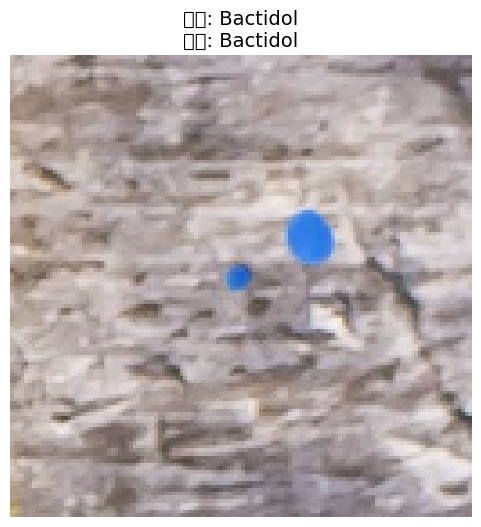

✅ 정답 약 이름: Bactidol
✅ 모델의 예측: Bactidol

정확하게 예측했습니다! 🎉


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트할 이미지 선택 (0부터 699 사이의 숫자를 바꿔보세요)
image_index = 55 

# 테스트 데이터셋에서 이미지와 정답 레이블 가져오기
test_image = X_test[image_index]
true_label_one_hot = y_test[image_index]

# 원-핫 인코딩된 정답 레이블을 다시 약 이름으로 변환
true_label_index = np.argmax(true_label_one_hot)
true_label_name = label_encoder.inverse_transform([true_label_index])[0]

# 모델 예측을 위해 이미지 형태 변경 (1, 128, 128, 3)
image_for_prediction = np.expand_dims(test_image, axis=0)

# 모델을 사용해 예측 수행
prediction_probabilities = model.predict(image_for_prediction)
predicted_index = np.argmax(prediction_probabilities)

# 예측된 인덱스를 약 이름으로 변환
predicted_label_name = label_encoder.inverse_transform([predicted_index])[0]

# --- 결과 시각화 ---
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title(f"정답: {true_label_name}\n예측: {predicted_label_name}", fontsize=14)
plt.axis('off')
plt.show()

print(f"✅ 정답 약 이름: {true_label_name}")
print(f"✅ 모델의 예측: {predicted_label_name}")

if true_label_name == predicted_label_name:
    print("\n정확하게 예측했습니다! 🎉")
else:
    print("\n예측이 틀렸습니다. 😥")